In [2]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_ollama import OllamaLLM
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
import gradio as gr
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def create_chatbot(file_path):
    # Load and split the PDF
    loader = PyPDFLoader(file_path)
    documents = loader.load()
    
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=50
    )
    splits = text_splitter.split_documents(documents)

    # Create embeddings and vector store
    embeddings = HuggingFaceEmbeddings(
        model_name="all-MiniLM-L6-v2",
        model_kwargs={'device': 'cpu'}
    )
    vectorstore = FAISS.from_documents(splits, embeddings)

    # Initialize Ollama
    llm = OllamaLLM(model="llama2")

    memory = ConversationBufferMemory(
        memory_key="chat_history",
        return_messages=True,
        output_key="answer"
    )

    qa_chain = ConversationalRetrievalChain.from_llm(
        llm=llm,
        retriever=vectorstore.as_retriever(search_kwargs={'k': 3}),
        memory=memory,
        return_source_documents=True
    )
    
    return qa_chain

# Keep your existing create_chatbot function
qa_chain = create_chatbot("DSM_5_TR.pdf")  # Initialize with default PDF




C:\Users\krish\AppData\Local\Temp\ipykernel_19196\2391077350.py:22: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(


Loading models...


100%|███████████████████████████████████████| 139M/139M [00:09<00:00, 15.3MiB/s]
Device set to use cpu


Models loaded successfully!
Loading audio file: divyanka_stress_possible.ogg
Audio duration: 12.73 seconds

Transcribing audio...
Error during transcription: [WinError 2] The system cannot find the file specified

Extracting audio features...
Feature extraction complete!

Analysis Results:
--------------------------------------------------
Stress Level: 14.8%
Interpretation: Low stress detected. Speech patterns and content suggest a calm state.

Transcribed Text:
--------------------------------------------------



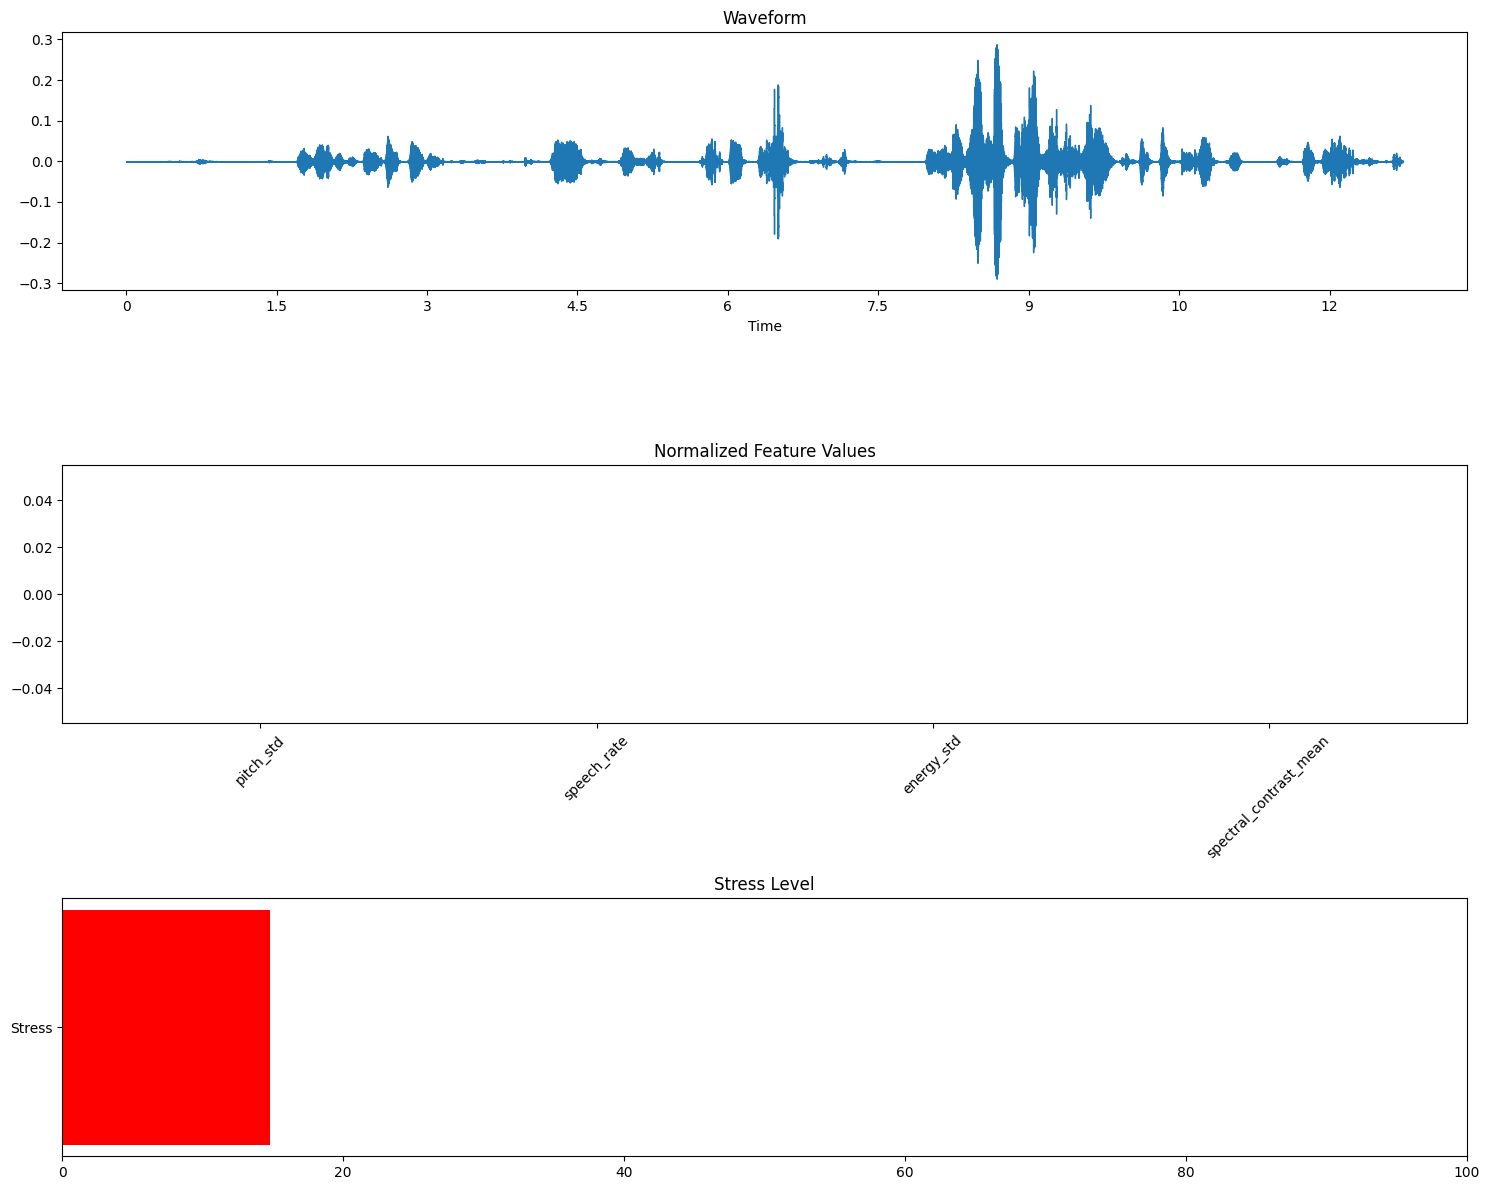

In [10]:

import numpy as np
import librosa
import torch
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import whisper # Changed import statement
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

class EnhancedAudioAnalyzer:
    def __init__(self, file_path):
        self.file_path = file_path
        self.audio = None
        self.sr = None
        self.features = {}
        self.text = None
        
        # Initialize models
        print("Loading models...")
        try:
            self.whisper_model = whisper.load_model("base")
            self.sentiment_analyzer = pipeline("sentiment-analysis", 
                                            model="distilbert-base-uncased-finetuned-sst-2-english",
                                            device=-1)  # Added device=-1 for CPU usage
            print("Models loaded successfully!")
        except Exception as e:
            print(f"Error loading models: {str(e)}")
            raise
        
        # Initialize scaler for feature normalization
        self.scaler = MinMaxScaler()
        
    def load_audio(self):
        """Load the audio file"""
        print(f"Loading audio file: {self.file_path}")
        try:
            self.audio, self.sr = librosa.load(self.file_path)
            duration = librosa.get_duration(y=self.audio, sr=self.sr)
            print(f"Audio duration: {duration:.2f} seconds")
            return self.audio, self.sr
        except Exception as e:
            print(f"Error loading audio: {str(e)}")
            raise
    
    def transcribe_audio(self):
        """Transcribe audio to text using Whisper"""
        print("\nTranscribing audio...")
        try:
            result = self.whisper_model.transcribe(self.file_path)
            self.text = result["text"]
            print(f"Transcribed text: {self.text}")
            return self.text
        except Exception as e:
            print(f"Error during transcription: {str(e)}")
            self.text = ""
            return self.text
    
    def extract_audio_features(self):
        """Extract acoustic features"""
        print("\nExtracting audio features...")
        try:
            # Time-domain features
            zero_crossings = librosa.zero_crossings(self.audio)
            speech_rate = sum(zero_crossings) / len(self.audio)
            
            # Frequency-domain features
            pitches, magnitudes = librosa.piptrack(y=self.audio, sr=self.sr)
            valid_pitches = pitches[magnitudes > np.max(magnitudes)/3]
            pitch_mean = np.mean(valid_pitches) if len(valid_pitches) > 0 else 0
            pitch_std = np.std(valid_pitches) if len(valid_pitches) > 0 else 0
            
            # Energy features
            rmse = librosa.feature.rms(y=self.audio)[0]
            energy_mean = np.mean(rmse)
            energy_std = np.std(rmse)
            
            # Spectral features
            spectral_centroids = librosa.feature.spectral_centroid(y=self.audio, sr=self.sr)[0]
            spectral_rolloff = librosa.feature.spectral_rolloff(y=self.audio, sr=self.sr)[0]
            spectral_contrast = librosa.feature.spectral_contrast(y=self.audio, sr=self.sr)
            
            # MFCCs
            mfccs = librosa.feature.mfcc(y=self.audio, sr=self.sr, n_mfcc=13)
            
            self.features = {
                'pitch_mean': pitch_mean,
                'pitch_std': pitch_std,
                'speech_rate': speech_rate,
                'energy_mean': energy_mean,
                'energy_std': energy_std,
                'spectral_centroid_mean': np.mean(spectral_centroids),
                'spectral_rolloff_mean': np.mean(spectral_rolloff),
                'spectral_contrast_mean': np.mean(spectral_contrast),
                'mfcc_mean': np.mean(mfccs),
                'mfcc_std': np.std(mfccs)
            }
            
            # Normalize features
            feature_values = np.array(list(self.features.values())).reshape(1, -1)
            normalized_features = self.scaler.fit_transform(feature_values)
            
            for i, key in enumerate(self.features.keys()):
                self.features[key] = normalized_features[0][i]
            
            print("Feature extraction complete!")
            return self.features
            
        except Exception as e:
            print(f"Error extracting features: {str(e)}")
            raise
    
    def analyze_text_sentiment(self):
        """Analyze sentiment of transcribed text"""
        if not self.text:
            return None
        
        try:
            sentiment_result = self.sentiment_analyzer(self.text)[0]
            return {
                'label': sentiment_result['label'],
                'score': sentiment_result['score']
            }
        except Exception as e:
            print(f"Error in sentiment analysis: {str(e)}")
            return None
    
    def calculate_stress_score(self):
        """Calculate combined stress score using both audio and text features"""
        # Audio feature weights (adjusted for better balance)
        audio_weights = {
            'pitch_std': 0.2,
            'speech_rate': 0.15,
            'energy_std': 0.2,
            'spectral_contrast_mean': 0.15
        }
        
        # Calculate audio-based score
        audio_score = sum(self.features[feature] * weight 
                         for feature, weight in audio_weights.items())
        
        # Get text-based sentiment score
        sentiment = self.analyze_text_sentiment()
        sentiment_score = 0.5  # Default neutral score if no text analysis
        if sentiment:
            # Convert sentiment to stress score (NEGATIVE sentiment → higher stress)
            sentiment_score = 1.0 - sentiment['score'] if sentiment['label'] == 'POSITIVE' else sentiment['score']
        
        # Combine scores (70% audio features, 30% text sentiment)
        final_score = (audio_score * 0.7 + sentiment_score * 0.3) * 100
        
        # Apply sigmoid-like scaling to avoid extreme values
        final_score = 100 * (1 / (1 + np.exp(-0.05 * (final_score - 50))))
        
        return max(0, min(100, final_score))
    
    def get_stress_interpretation(self, stress_score):
        """Interpret stress score"""
        if stress_score < 30:
            return "Low stress detected. Speech patterns and content suggest a calm state."
        elif stress_score < 60:
            return "Moderate stress detected. Some indicators of tension present."
        else:
            return "High stress detected. Multiple indicators suggest elevated stress levels."
    
    def visualize_analysis(self, stress_score):
        """Create visualizations of the analysis"""
        plt.figure(figsize=(15, 12))
        
        # Waveform
        plt.subplot(3, 1, 1)
        librosa.display.waveshow(self.audio, sr=self.sr)
        plt.title('Waveform')
        
        # Feature importance
        plt.subplot(3, 1, 2)
        features_to_plot = {k: v for k, v in self.features.items() 
                          if k in ['pitch_std', 'speech_rate', 'energy_std', 'spectral_contrast_mean']}
        plt.bar(features_to_plot.keys(), features_to_plot.values())
        plt.xticks(rotation=45)
        plt.title('Normalized Feature Values')
        
        # Stress meter
        plt.subplot(3, 1, 3)
        plt.barh(['Stress'], [stress_score], color='red')
        plt.xlim(0, 100)
        plt.title('Stress Level')
        
        plt.tight_layout()
        plt.show()

def main():
    # Initialize analyzer with your audio file
    analyzer = EnhancedAudioAnalyzer('divyanka_stress_possible.ogg')
    
    try:
        # Process audio
        analyzer.load_audio()
        analyzer.transcribe_audio()
        analyzer.extract_audio_features()
        
        # Calculate stress score
        stress_score = analyzer.calculate_stress_score()
        interpretation = analyzer.get_stress_interpretation(stress_score)
        
        # Get sentiment analysis
        sentiment = analyzer.analyze_text_sentiment()
        
        # Print results
        print("\nAnalysis Results:")
        print("-" * 50)
        print(f"Stress Level: {stress_score:.1f}%")
        print(f"Interpretation: {interpretation}")
        if sentiment:
            print(f"Text Sentiment: {sentiment['label']} (confidence: {sentiment['score']:.2f})")
        
        print("\nTranscribed Text:")
        print("-" * 50)
        print(analyzer.text)
        
        # Create visualizations
        analyzer.visualize_analysis(stress_score)
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

In [16]:
def create_interface():
    # Initialize analyzer and get initial analysis once
    analyzer = EnhancedAudioAnalyzer('divyanka_stress_possible.ogg')
    analyzer.load_audio()
    analyzer.transcribe_audio()
    analyzer.extract_audio_features()
    stress_score = analyzer.calculate_stress_score()
    interpretation = analyzer.get_stress_interpretation(stress_score)

    def answer_question(message, history):
        if not message:
            return []
        
        # Enhanced system prompt with stress analysis
        prompt = f"""You are a compassionate mental health assistant. 
Initial voice analysis shows:
- Stress Level: {stress_score:.1f}%
- Interpretation: {interpretation}

Please keep this context in mind while responding. Based on this information and the user's messages:
1. Show empathy and understanding
2. Ask relevant questions about their emotional state
3. Provide supportive guidance
4. Monitor for signs of severe distress"""

        result = qa_chain.invoke({
            "question": f"{prompt}\n\nUser message: {message}"
        })
        
        history = history or []
        history.append([message, result['answer']])  # Changed to list format
        return history

    with gr.Blocks(theme=gr.themes.Soft(
        primary_hue="teal",
        secondary_hue="indigo",
    )) as demo:
        gr.Markdown(
            """
            # 🌟 Mental Health Support Assistant
            ### A Safe Space for Mental Health Assessment
            
            *This AI assistant is trained to help assess your mental well-being and provide supportive guidance.
            While it uses advanced analysis techniques, it's not a replacement for professional medical advice.*
            """
        )
        
        with gr.Row():
            with gr.Column(scale=4):
                chatbot = gr.Chatbot(
                    value=[[None, f"Based on voice analysis:\nStress Level: {stress_score:.1f}%\nInterpretation: {interpretation}\n\nHow are you feeling right now? Would you like to tell me more about what's on your mind?"]],  # Changed to list format
                    height=500,
                    container=True,
                    bubble_full_width=False,
                    show_copy_button=True,
                    avatar_images=("👤", "🤖")
                )
                
                with gr.Row():
                    msg = gr.Textbox(
                        label="Share your thoughts...",
                        placeholder="How are you feeling today? I'm here to listen and support...",
                        lines=2,
                        scale=4
                    )
                    submit = gr.Button("Send", variant="primary", scale=1)
                
                with gr.Row():
                    clear = gr.Button("Clear Chat", variant="secondary")
                    
            with gr.Column(scale=1):
                gr.Markdown(
                    """
                    ### 📌 Important Resources
                    
                    **Emergency Contacts:**
                    - National Crisis Helpline: 988
                    - Emergency Services: 911
                    
                    **Remember:**
                    - Mental health matters
                    - It's okay to ask for help
                    - You're not alone
                    - Seeking help is strength
                    """
                )

        msg.submit(
            fn=answer_question,
            inputs=[msg, chatbot],
            outputs=[chatbot]
        ).then(
            fn=lambda: "",
            outputs=msg
        )
        
        submit.click(
            fn=answer_question,
            inputs=[msg, chatbot],
            outputs=[chatbot]
        ).then(
            fn=lambda: "",
            outputs=msg
        )
        
        clear.click(lambda: [], None, chatbot)

    return demo

if __name__ == "__main__":
    demo = create_interface()
    demo.launch(
        server_name="localhost",
        server_port=8086,
        share=True
    )

Loading models...


Device set to use cpu


Models loaded successfully!
Loading audio file: divyanka_stress_possible.ogg
Audio duration: 12.73 seconds

Transcribing audio...
Error during transcription: [WinError 2] The system cannot find the file specified

Extracting audio features...
Feature extraction complete!
* Running on local URL:  http://localhost:8086

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.
